<a href="https://colab.research.google.com/github/JyothsnaGH/PythonforFinance/blob/main/Credit_Rating_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import pandas as pd
import numpy as np
from numpy import loadtxt
from numpy import sort
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
from random import sample
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

The data is obtained from: https://github.com/Agewerc/ML-Finance/blob/master/data/corporate_rating.csv

In [96]:
df_rating = pd.read_csv('https://raw.githubusercontent.com/Agewerc/ML-Finance/master/data/corporate_rating.csv')
df_rating.head()

,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
0,A,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,11/27/2015,Consumer Durables,0.945894,0.426395,0.099690,44.203245,...,0.202716,0.437551,6.810673,9.809403,4.008012,0.049351,7.057088,15.565438,0.058638,3.906655
1,BBB,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,2/13/2014,Consumer Durables,1.033559,0.498234,0.203120,38.991156,...,0.074155,0.541997,8.625473,17.402270,3.156783,0.048857,6.460618,15.914250,0.067239,4.002846
2,BBB,Whirlpool Corporation,WHR,Fitch Ratings,3/6/2015,Consumer Durables,0.963703,0.451505,0.122099,50.841385,...,0.214529,0.513185,9.693487,13.103448,4.094575,0.044334,10.491970,18.888889,0.074426,3.483510
3,BBB,Whirlpool Corporation,WHR,Fitch Ratings,6/15/2012,Consumer Durables,1.019851,0.510402,0.176116,41.161738,...,1.816667,-0.147170,-1.015625,14.440104,3.630950,-0.012858,4.080741,6.901042,0.028394,4.581150
4,BBB,Whirlpool Corporation,WHR,Standard & Poor's Ratings Services,10/24/2016,Consumer Durables,0.957844,0.495432,0.141608,47.761126,...,0.166966,0.451372,7.135348,14.257556,4.012780,0.053770,8.293505,15.808147,0.058065,3.857790


In [97]:
print("The credit rating dataset has", df_rating.shape[0], "records, each with", df_rating.shape[1],
    "attributes")
df_rating.info()

The credit rating dataset has 2029 records, each with 31 attributes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2029 entries, 0 to 2028
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Rating                              2029 non-null   object 
 1   Name                                2029 non-null   object 
 2   Symbol                              2029 non-null   object 
 3   Rating Agency Name                  2029 non-null   object 
 4   Date                                2029 non-null   object 
 5   Sector                              2029 non-null   object 
 6   currentRatio                        2029 non-null   float64
 7   quickRatio                          2029 non-null   float64
 8   cashRatio                           2029 non-null   float64
 9   daysOfSalesOutstanding              2029 non-null   float64
 10  netProfitMargin                     2029

In [98]:
df_rating.Rating.value_counts()

,count
Rating,
BBB,671
BB,490
A,398
B,302
AA,89
CCC,64
AAA,7
CC,5
C,2


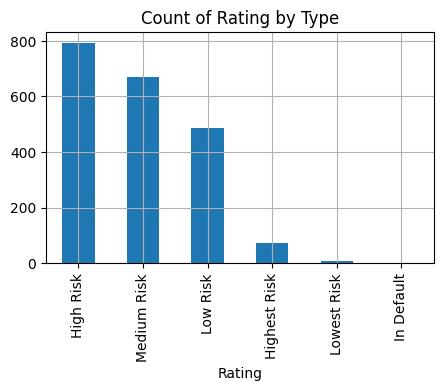

In [99]:
rating_dict = {'AAA':'Lowest Risk',  'AA':'Low Risk',  'A':'Low Risk', 'BBB':'Medium Risk', 'BB':'High Risk', 'B':'High Risk', 'CCC':'Highest Risk', 'CC':'Highest Risk',  'C':'Highest Risk', 'D':'In Default'}

df_rating.Rating = df_rating.Rating.map(rating_dict)
ax = df_rating['Rating'].value_counts().plot(kind='bar', figsize=(5,3), title="Count of Rating by Type",grid=True)

In [100]:
df_rating = df_rating[df_rating['Rating']!='Lowest Risk'] # filter Lowest Risk
df_rating = df_rating[df_rating['Rating']!='In Default']  # filter In Default
df_rating.reset_index(inplace = True, drop=True) # reset index

In [101]:
df_rating.describe()

,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,netProfitMargin,pretaxProfitMargin,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnCapitalEmployed,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
count,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000,...,2021.000000,2021.000000,2.021000e+03,2.021000e+03,2021.000000,2021.000000,2021.000000,2.021000e+03,2021.000000,2021.000000
mean,3.535411,2.657150,0.669048,334.855415,0.278725,0.432721,0.496900,0.588793,-37.666843,-74.267283,...,0.400755,0.408272,5.114871e+03,4.244248e+03,3.335166,0.438715,48.426558,6.540891e+03,1.452142,38.138233
std,44.139386,33.009920,3.590902,4456.606352,6.076128,9.002733,0.525996,11.246798,1168.476782,2354.920503,...,10.613711,3.803929,1.472059e+05,1.226418e+05,87.702375,9.002047,530.161001,1.778797e+05,19.521704,760.421855
min,-0.932005,-1.893266,-0.192736,-811.845623,-101.845815,-124.343612,-14.800817,-124.343612,-40213.178290,-87162.162160,...,-100.611015,-120.916010,-4.912742e+03,-1.915035e+01,-2555.419643,-124.343612,-3749.921337,-1.195049e+04,-4.461837,-76.662850
25%,1.071930,0.602298,0.131433,22.806507,0.020894,0.025649,0.232565,0.044546,0.018757,0.028112,...,0.147837,0.269616,4.094118e-01,1.562116e+00,2.050249,0.028057,6.235759,2.348851e+00,0.073664,2.202394
50%,1.492804,0.979094,0.297859,42.281804,0.064323,0.084965,0.414217,0.107640,0.045417,0.074639,...,0.300439,0.644265,2.123062e+00,3.680425e+00,2.657275,0.087424,9.269746,4.361649e+00,0.132758,5.775840
75%,2.160710,1.450457,0.625355,59.165369,0.113871,0.144763,0.849693,0.175334,0.077159,0.135036,...,0.370239,0.836949,4.230253e+00,8.027524e+00,3.665438,0.149355,12.898855,7.322553e+00,0.239359,9.500424
max,1725.505005,1139.541703,125.917417,115961.637400,198.517873,309.694856,2.702533,410.182214,0.487826,2.439504,...,429.926282,34.594086,5.753380e+06,4.786803e+06,2562.871795,309.694856,11153.607090,6.439270e+06,688.526591,20314.880400


['daysOfSalesOutstanding', 'cashPerShare', 'freeCashFlowPerShare', 'enterpriseValueMultiple']


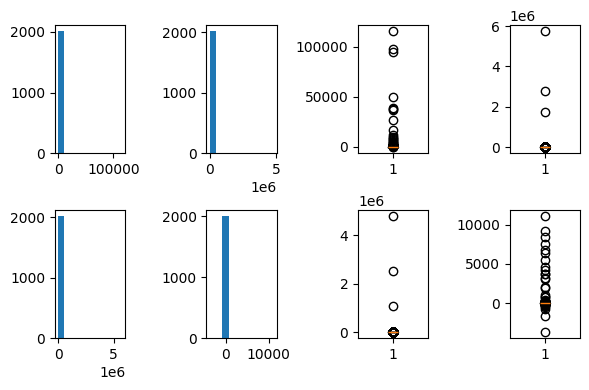

In [102]:
column_list = list(df_rating.columns[6:31])
column_list = sample(column_list,4)
print(column_list)
figure, axes = plt.subplots(nrows=2, ncols=4, figsize=(6,4))

axes[0, 0].hist(df_rating[column_list[0]])
axes[0, 1].hist(df_rating[column_list[1]])
axes[1, 0].hist(df_rating[column_list[2]])
axes[1, 1].hist(df_rating[column_list[3]])

axes[0, 2].boxplot(df_rating[column_list[0]])
axes[1, 2].boxplot(df_rating[column_list[1]])
axes[0, 3].boxplot(df_rating[column_list[2]])
axes[1, 3].boxplot(df_rating[column_list[3]])

figure.tight_layout()

## Now that we have this dataframe we can use it use it to observe the data from a different angle. We will be able to observe the distribution that was hidden by the outliers. The first step:

### Plot all columns (boxplot) by each label:High Risk, Low Risk, Medium Risk, Highest Risk.

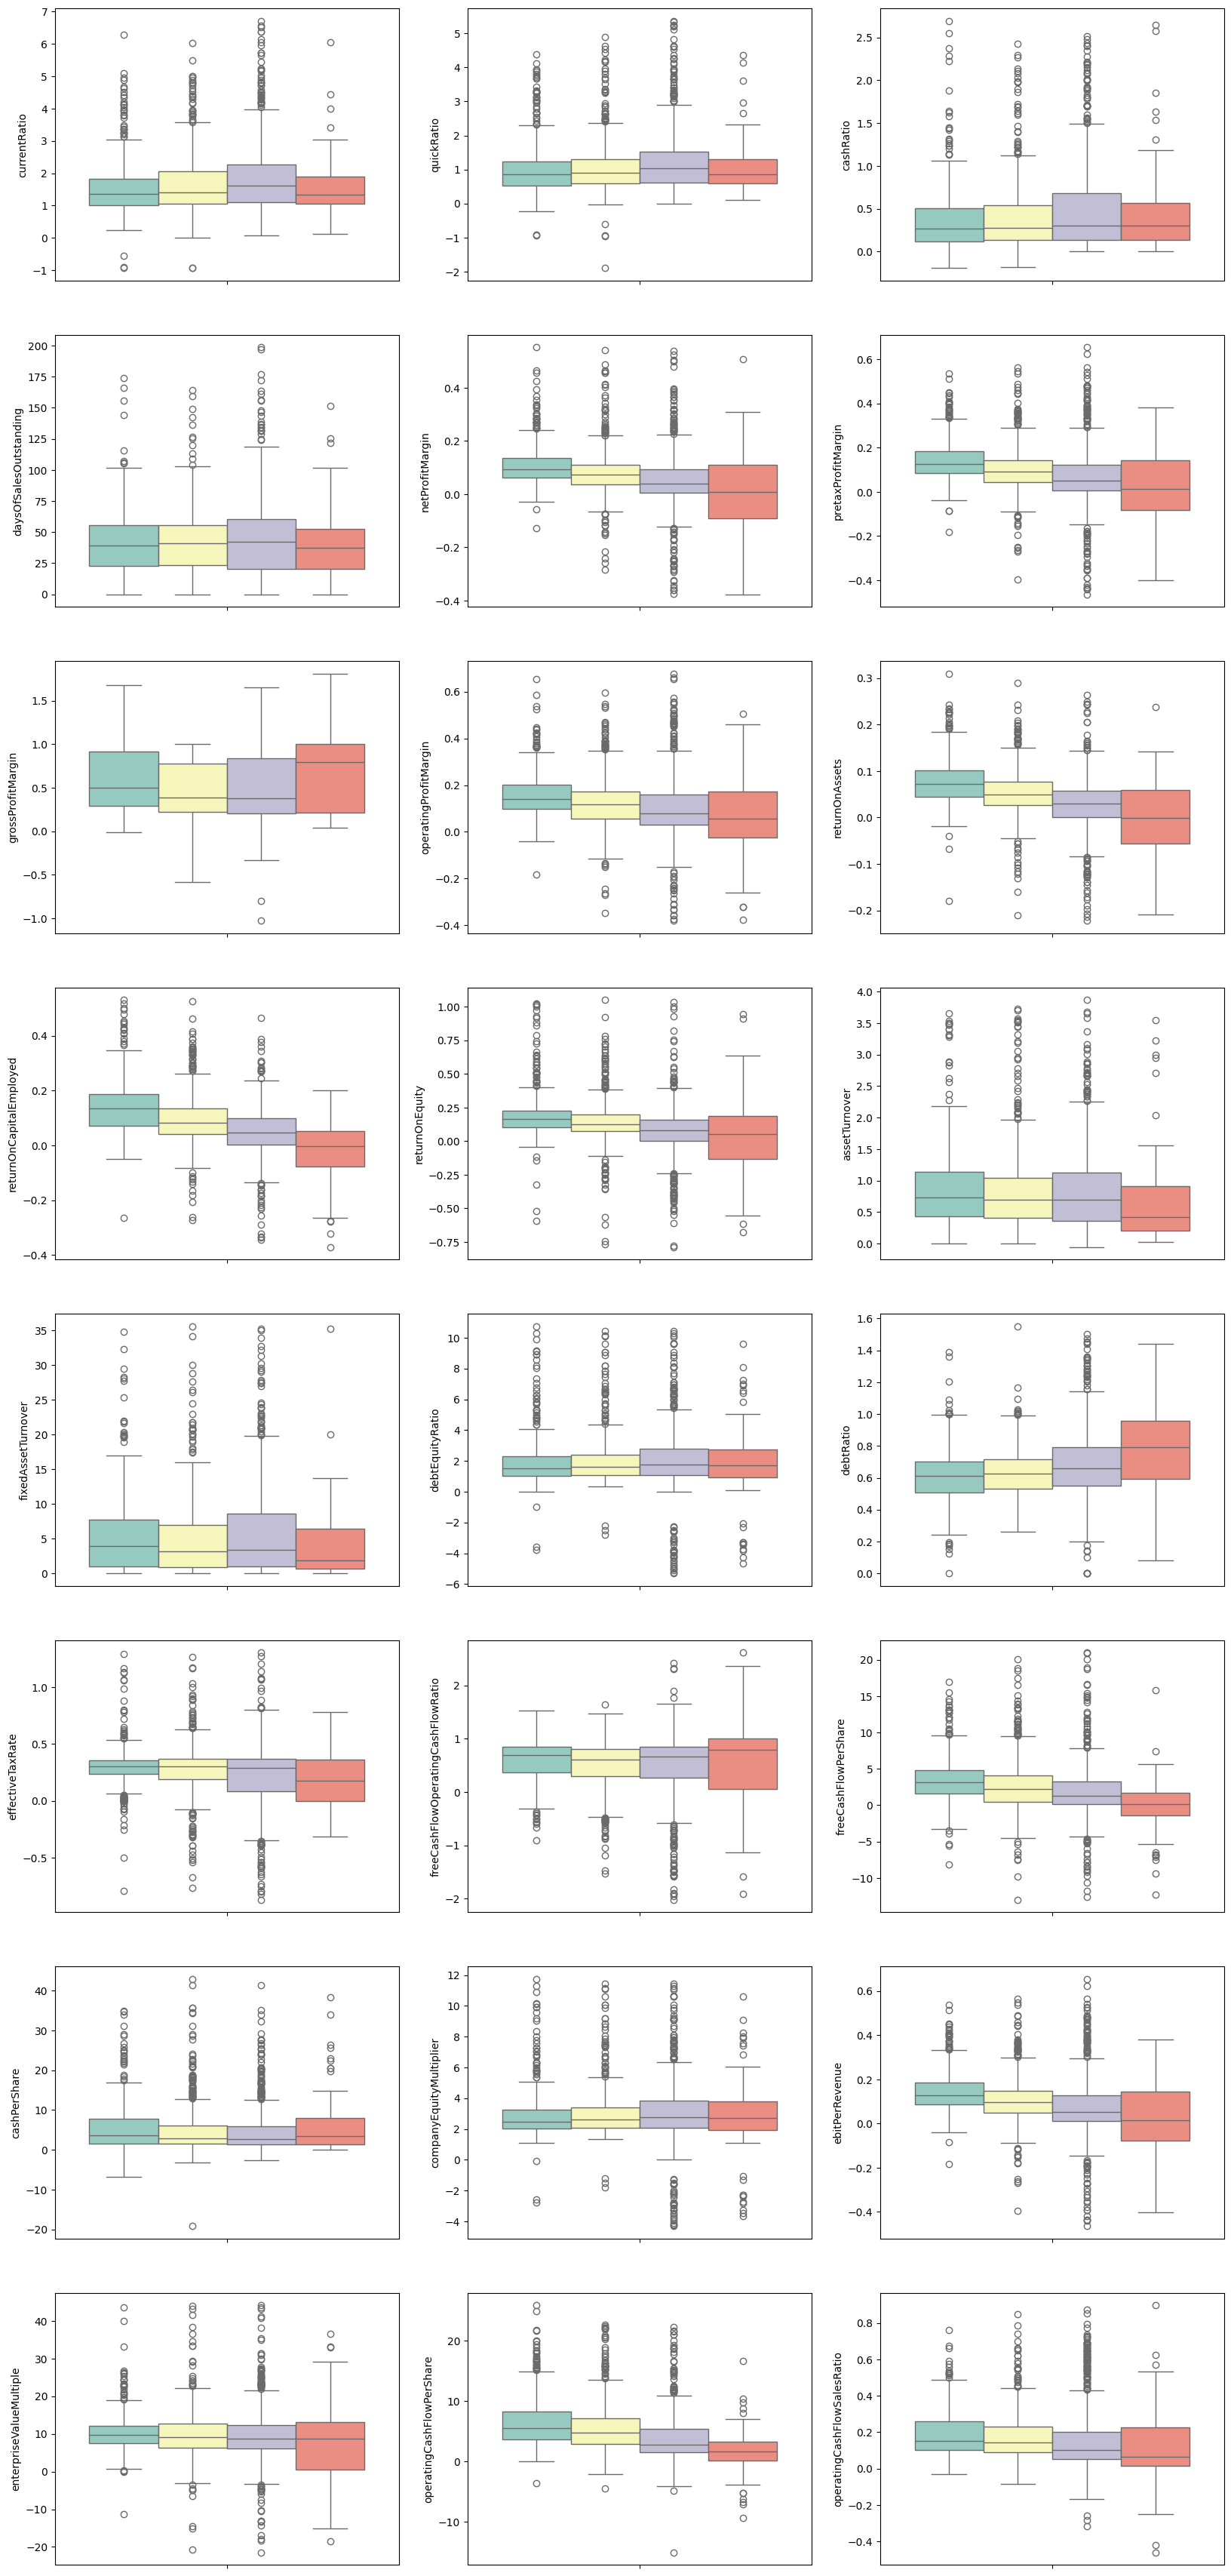

In [103]:
df_rating_no_out = df_rating.copy()

for c in df_rating_no_out.columns[6:31]:

    q05 = df_rating_no_out[c].quantile(0.10)
    q95 = df_rating_no_out[c].quantile(0.90)
    iqr = q95 - q05 #Interquartile range
    fence_low  = q05-1.5*iqr
    fence_high = q95+1.5*iqr
    df_rating_no_out.loc[df_rating_no_out[c] > fence_high,c] = df_rating_no_out[c].quantile(0.25)
    df_rating_no_out.loc[df_rating_no_out[c] < fence_low,c] = df_rating_no_out[c].quantile(0.75)

figure, axes = plt.subplots(nrows=8, ncols=3, figsize=(20,44))

i = 0
j = 0

for c in df_rating_no_out.columns[6:30]:

    sns.boxplot(hue=df_rating_no_out.Rating, y=df_rating_no_out[c], palette="Set3",ax=axes[i, j], legend = False)

    if j == 2:
        j=0
        i+=1
    else:
        j+=1

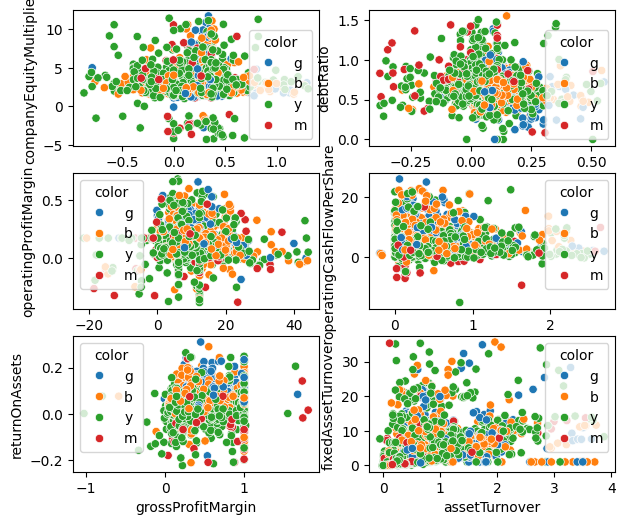

In [104]:
df_rating.colors = 'a'
df_rating_no_out.loc[df_rating_no_out['Rating'] == 'Lowest Risk', 'color'] = 'r'
df_rating_no_out.loc[df_rating_no_out['Rating'] == 'Low Risk', 'color'] = 'g'
df_rating_no_out.loc[df_rating_no_out['Rating'] == 'Medium Risk', 'color'] = 'b'
df_rating_no_out.loc[df_rating_no_out['Rating'] == 'High Risk','color'] = 'y'
df_rating_no_out.loc[df_rating_no_out['Rating'] == 'Highest Risk', 'color'] = 'm'
column_list = list(df_rating.columns[6:31])
column_list = sample(column_list,12)
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(7,6))

i = 0
j = 0

for c in range(0,12, 2):

    sns.scatterplot(x = column_list[c], y=column_list[c+1], hue="color", data=df_rating_no_out, ax=axes[j,i])

    if i == 1:
        i = 0
        j +=1

    else:
        i+=1


In [105]:
le = preprocessing.LabelEncoder()
le.fit(df_rating.Sector)
df_rating.Sector = le.transform(df_rating.Sector) # encode sector
le.fit(df_rating.Rating)
df_rating.Rating = le.transform(df_rating.Rating) # encode rating
df_train, df_test = train_test_split(df_rating, test_size=0.2, random_state = 1234)
X_train, y_train = df_train.iloc[:,5:31], df_train.iloc[:,0]
X_test, y_test = df_test.iloc[:,5:31], df_test.iloc[:,0]

In [106]:
LR_model = LogisticRegression(random_state=1234 , solver='newton-cg')
LR_model = LR_model.fit(X_train, y_train)
y_pred_LR = LR_model.predict(X_test)
Accuracy_LR = metrics.accuracy_score(y_test, y_pred_LR)
print("LR Accuracy:",Accuracy_LR)

LR Accuracy: 0.45185185185185184


/usr/local/lib/python3.11/dist-packages/sklearn/utils/optimize.py:319: ConvergenceWarning: newton-cg failed to converge at loss = 1.0562435328218027. Increase the number of iterations.
  warnings.warn(


## **K-Nearest Neighbor**

In [107]:
KNN_model = KNeighborsClassifier(n_neighbors = 3)
KNN_model.fit(X_train,y_train)
y_pred_KNN = KNN_model.predict(X_test)
Accuracy_KNN = metrics.accuracy_score(y_test, y_pred_KNN)
print("KNN Accuracy:",Accuracy_KNN)

KNN Accuracy: 0.562962962962963


## **Decision Tree**

In [108]:
DT_model = DecisionTreeClassifier(random_state=99)
DT_model.fit(X_train,y_train)
y_pred_DT = DT_model.predict(X_test)
Accuracy_DT = metrics.accuracy_score(y_test, y_pred_DT)
print("Decision Tree Accuracy:",Accuracy_DT)

Decision Tree Accuracy: 0.5580246913580247


## **Random Forest**

In [109]:
RF_model = RandomForestClassifier(random_state=1234)
RF_model.fit(X_train,y_train)
y_pred_RF = RF_model.predict(X_test)
Accuracy_RF = metrics.accuracy_score(y_test, y_pred_RF)
print("RF Accuracy:",Accuracy_RF)

RF Accuracy: 0.6419753086419753


<ipython-input-110-8597d75cfde1>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  x = sns.barplot(x='Model', y="Accuracy", data=df_accuracy, order = order, palette="rocket", legend = False)
<ipython-input-110-8597d75cfde1>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_value)


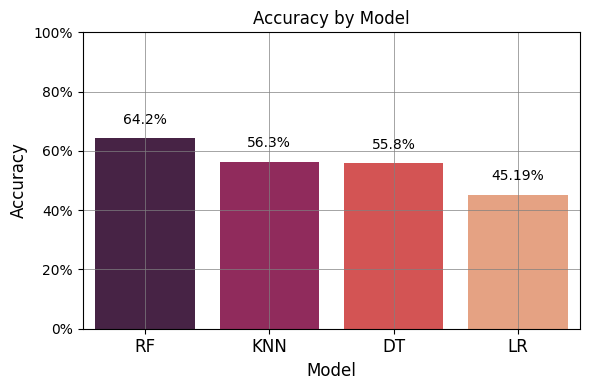

In [110]:
accuracy_list = [Accuracy_DT, Accuracy_RF, Accuracy_KNN, Accuracy_LR]
model_list = ['DT', 'RF', 'KNN', 'LR']

df_accuracy = pd.DataFrame({'Model': model_list, 'Accuracy': accuracy_list})
order = list(df_accuracy.sort_values('Accuracy', ascending=False).Model)
df_accuracy = df_accuracy.sort_values('Accuracy', ascending=False).reset_index().drop(['index'], axis=1)

plt.figure(figsize=(6,4))
# make barplot and sort bars
x = sns.barplot(x='Model', y="Accuracy", data=df_accuracy, order = order, palette="rocket", legend = False)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy by Model", fontsize=12)
plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.xticks(rotation=0, fontsize=12)
plt.ylim(0,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

for i in range(len(model_list)):
    plt.text(x = i, y = df_accuracy.loc[i, 'Accuracy'] + 0.05, s = str(round((df_accuracy.loc[i, 'Accuracy'])*100, 2))+'%',
             fontsize = 10, color='black',horizontalalignment='center')

y_value=['{:,.2f}'.format(x) + '%' for x in ax.get_yticks()]
ax.set_yticklabels(y_value)

plt.tight_layout()

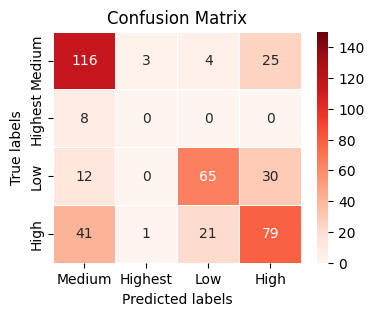

              precision    recall  f1-score   support

 Medium Risk       0.66      0.78      0.71       148
Highest Risk       0.00      0.00      0.00         8
    Low Risk       0.72      0.61      0.66       107
   High Risk       0.59      0.56      0.57       142

    accuracy                           0.64       405
   macro avg       0.49      0.49      0.49       405
weighted avg       0.64      0.64      0.64       405



In [111]:
cm = confusion_matrix(y_test, y_pred_RF)
fig, ax = plt.subplots(figsize=(4,3))

sns.heatmap(cm, annot = True, ax = ax, vmin=0, vmax=150, fmt="d", linewidths=.5, linecolor = 'white', cmap="Reds") # annot=True to annotate cells
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Medium','Highest', 'Low', 'High'])
ax.yaxis.set_ticklabels(['Medium','Highest', 'Low', 'High']);

plt.show()

print(classification_report(y_test, y_pred_RF, target_names = ['Medium Risk','Highest Risk', 'Low Risk', 'High Risk']))

In [112]:
# .iloc[:,5:31]
feature_names = df_rating.columns[5:31]
importances = RF_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
print(feature_imp_df)

                               Feature  Gini Importance
23           operatingCashFlowPerShare         0.059711
9                       returnOnAssets         0.052009
10             returnOnCapitalEmployed         0.051512
24         operatingCashFlowSalesRatio         0.047902
5                      netProfitMargin         0.046187
21                      ebitPerRevenue         0.042412
3                            cashRatio         0.041488
6                   pretaxProfitMargin         0.040319
16                    effectiveTaxRate         0.039306
22             enterpriseValueMultiple         0.038908
13                  fixedAssetTurnover         0.038243
11                      returnOnEquity         0.037204
1                         currentRatio         0.036807
17  freeCashFlowOperatingCashFlowRatio         0.036005
18                freeCashFlowPerShare         0.035937
12                       assetTurnover         0.035731
15                           debtRatio         0

Text(0.5, 1.0, 'Feature Importance - Gini Importance')

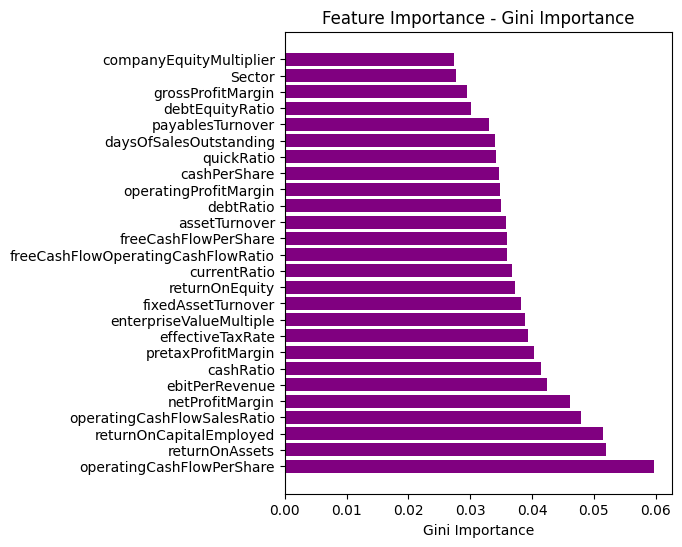

In [114]:
plt.figure(figsize=(5, 6))
plt.barh(feature_imp_df['Feature'], feature_imp_df['Gini Importance'], color = 'purple')
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')